# 1. Setup

In [14]:
# Standard library
from pathlib import Path
import tomllib

# Core libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print

# Machine learning – preprocessing & modelling
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# Machine learning – evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    make_scorer,
    recall_score
)

# Set random seed for reproducibility
np.random.seed(42)

In [15]:
# Load configuration
with open('config.toml', 'rb') as f:
   config = tomllib.load(f)

print("✅ Configuration loaded")

# Load dataset
dataset_path = Path('datasets/dataset_raw.csv')
df = pd.read_csv(dataset_path, delimiter=';')

print(f"✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]:,} columns")


✅ Configuration loaded

✅ Dataset loaded: 4,424 rows × 37 columns

In [16]:
# Create binary target (1=Withdrawal, 0=Continue)
df['target_binary'] = df['Target'].map({'Dropout': 1, 'Graduate': 0, 'Enrolled': 0})

In [17]:
print(f" - Final dataset: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

- Final dataset: 4,424 rows × 38 columns

# 2. Feature Selection

In [18]:
def normalise_column_names(df):
    """Normalise DataFrame column names to snake_case format"""
    def to_snake_case(name):
        # Convert to string, strip whitespace, lowercase
        name = str(name).strip().lower()
        # Replace spaces and apostrophes with underscores
        name = name.replace(' ', '_').replace("'", '')
        # Remove special characters
        name = name.replace('(', '').replace(')', '').replace('/', '_')
        name = name.replace('-', '_').replace('.', '_')
        # Clean up multiple underscores
        while '__' in name:
            name = name.replace('__', '_')
        # Remove trailing/leading underscores
        name = name.strip('_')
        return name
    
    df_copy = df.copy()
    original_cols = df_copy.columns.tolist()
    df_copy.columns = [to_snake_case(col) for col in df_copy.columns]
    
    # Validate no duplicate columns after normalization
    if len(set(df_copy.columns)) != len(df_copy.columns):
        duplicates = [col for col in df_copy.columns if df_copy.columns.tolist().count(col) > 1]
        raise ValueError(f"Column normalization created duplicates: {duplicates}")
    
    return df_copy

# Apply single comprehensive normalization
df = normalise_column_names(df)
print('✅ Column names normalised comprehensively (single pass)')

✅ Column names normalised comprehensively (single pass)

In [19]:
# Feature removal - drop problematic features
features_to_drop = [
    # Data leakage - 2nd semester features (remove to prevent future leakage)
    'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_without_evaluations', 'curricular_units_2nd_sem_grade',
    # Severely imbalanced features (>97% in one category)
    'nacionality', 'educational_special_needs', 'international',
    # Zero information value features
    'daytime_evening_attendance', 'displaced',
    # Weak predictors (correlation < 0.10)
    'unemployment_rate', 'inflation_rate', 'gdp', 'previous_qualification_grade',
    # Multicollinearity - high VIF features (from EDA analysis)
    'curricular_units_1st_sem_approved',  # VIF: 6.38 (highest - must remove)
    'curricular_units_1st_sem_enrolled',  # VIF: 4.83 (moderate multicollinearity)
    # Original target column
    'target'
]

# Check which features actually exist before dropping
existing_features = [col for col in features_to_drop if col in df.columns]
missing_features = [col for col in features_to_drop if col not in df.columns]

if missing_features:
    print(f'⚠️ Warning: Expected features not found: {missing_features}')
    
print(f'🗑️ Dropping {len(existing_features)} features: {existing_features}')
print(f'✅ Multicollinearity addressed: Removed features with VIF > 4.5')
df = df.drop(columns=existing_features)

🗑️ Dropping 18 features: ['curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 
'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 
'curricular_units_2nd_sem_without_evaluations', 'curricular_units_2nd_sem_grade', 'nacionality', 
'educational_special_needs', 'international', 'daytime_evening_attendance', 'displaced', 'unemployment_rate', 
'inflation_rate', 'gdp', 'previous_qualification_grade', 'curricular_units_1st_sem_approved', 
'curricular_units_1st_sem_enrolled', 'target']

✅ Multicollinearity addressed: Removed features with VIF > 4.5

# 3. Train Test Split

In [20]:
# Prepare features and target
X = df.drop('target_binary', axis=1)
y = df['target_binary']

# Split the data using config parameters
train_size = config['logistic_regression_model']['train_size']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=train_size,
    stratify=y,
    random_state=42
)

# Apply withdrawal rate encoding AFTER split to prevent data leakage
def encode_withdrawal_rate_safe(X_train, X_test, y_train, col):
    """Encode withdrawal rates using training data only"""
    # Ensure explicit index alignment to prevent data corruption
    X_train_aligned = X_train.reset_index(drop=True)
    y_train_aligned = y_train.reset_index(drop=True)
    
    temp_df = pd.concat([X_train_aligned[col], (y_train_aligned == 0)], axis=1)
    temp_df.columns = [col, 'is_withdrawal']
    rates = temp_df.groupby(col)['is_withdrawal'].mean()
    global_rate = (y_train_aligned == 0).mean()  # Fallback for unseen categories
    
    X_train[f'{col}_withdrawal_rate'] = X_train[col].map(rates)
    X_test[f'{col}_withdrawal_rate'] = X_test[col].map(rates).fillna(global_rate)
    X_train = X_train.drop(columns=[col])
    X_test = X_test.drop(columns=[col])
    return X_train, X_test

# Apply to medium cardinality features
for col in ['application_mode', 'course', 'previous_qualification']:
    X_train, X_test = encode_withdrawal_rate_safe(X_train, X_test, y_train, col)

# Create parental features AFTER split to prevent data leakage
higher_ed_codes = config['parental_features']['higher_education_codes']
professional_codes = config['parental_features']['professional_occupation_codes']

for X in [X_train, X_test]:
    # Create parental higher education binary indicator
    X['parental_higher_education'] = (
        (X['mothers_qualification'].isin(higher_ed_codes)) |
        (X['fathers_qualification'].isin(higher_ed_codes))
    ).astype(int)
    
    # Create parental professional occupation binary indicator
    X['parental_professional_occupation'] = (
        (X['mothers_occupation'].isin(professional_codes)) |
        (X['fathers_occupation'].isin(professional_codes))
    ).astype(int)
    
    # Drop original parental features
    X.drop(columns=['mothers_qualification', 'fathers_qualification', 
                   'mothers_occupation', 'fathers_occupation'], inplace=True)

# Calculate percentages and display results
train_pct = int(train_size * 100)
test_pct = 100 - train_pct

print(f'📊 Data split ({train_pct}/{test_pct}):')
print(f'   Training: {X_train.shape[0]:,} samples')
print(f'   Test: {X_test.shape[0]:,} samples')

print(f'\n🎯 Class distribution:')
print(f'   Training: {y_train.value_counts().to_dict()}')
print(f'   Test: {y_test.value_counts().to_dict()}')

# Verify class balance is maintained
train_ratio = y_train.mean()
test_ratio = y_test.mean()
print(f'\n✅ Continuation rate: Train={train_ratio:.3f}, Test={test_ratio:.3f}')
print(f'✅ All feature encoding applied safely (training data only)')

📊 Data split (80/20):

Training: 3,539 samples

Test: 885 samples

🎯 Class distribution:

Training: {0: 2402, 1: 1137}

Test: {0: 601, 1: 284}

✅ Continuation rate: Train=0.321, Test=0.321

✅ All feature encoding applied safely (training data only)

# 4. Pipeline

In [21]:
# Get scaler type from config
scaler_type = config['logistic_regression_model']['scaler_type']

if scaler_type == 'standard':
    scaler = StandardScaler()
elif scaler_type == 'minmax':
    scaler = MinMaxScaler()
else:
    raise ValueError(f'Unknown scaler type: {scaler_type}')

# Get feature lists from config and filter for features that actually exist in our processed dataset
config_continuous = config['dataset_features']['continuous_features']
config_categorical = config['dataset_features']['categorical_features']

# Filter continuous features to only include those present after all transformations
continuous_features = [f for f in config_continuous if f in X_train.columns]

# Add withdrawal rate features if they were created successfully during preprocessing
expected_withdrawal_features = ['application_mode_withdrawal_rate', 'course_withdrawal_rate', 
                               'previous_qualification_withdrawal_rate']
existing_withdrawal_features = [f for f in expected_withdrawal_features if f in X_train.columns]
missing_withdrawal_features = [f for f in expected_withdrawal_features if f not in X_train.columns]

if missing_withdrawal_features:
    print(f'⚠️ Warning: Expected withdrawal rate features missing: {missing_withdrawal_features}')
    
print(f'✅ Found {len(existing_withdrawal_features)} withdrawal rate features: {existing_withdrawal_features}')
continuous_features.extend(existing_withdrawal_features)

# Filter categorical features to only include those present after transformations
categorical_features = [f for f in config_categorical if f in X_train.columns]

# Binary features created during preprocessing
binary_features = ['parental_higher_education', 'parental_professional_occupation']

# Verify all features are explicitly handled
all_handled_features = continuous_features + categorical_features + binary_features
actual_features = X_train.columns.tolist()
unhandled_features = set(actual_features) - set(all_handled_features)

if unhandled_features:
    print(f'⚠️ Unhandled features detected: {sorted(unhandled_features)}')
    print('🔧 Please categorise these features explicitly')
    raise ValueError(f'All features must be explicitly categorised. Unhandled: {unhandled_features}')

# Create preprocessing pipeline with explicit feature handling only
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler, continuous_features),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('passthrough', 'passthrough', binary_features)
    ],
    remainder='drop'
)

print(f'🔧 Preprocessing pipeline created:')
print(f'   Scaler: {scaler_type} (applied to {len(continuous_features)} continuous features)')
print(f'   One-hot encoder: {len(categorical_features)} categorical features')
print(f'   Binary features (no scaling): {len(binary_features)} features')
print(f'✅ All {len(all_handled_features)} features explicitly handled')

✅ Found 3 withdrawal rate features: ['application_mode_withdrawal_rate', 'course_withdrawal_rate', 
'previous_qualification_withdrawal_rate']

🔧 Preprocessing pipeline created:

Scaler: standard (applied to 9 continuous features)

One-hot encoder: 6 categorical features

Binary features (no scaling): 2 features

✅ All 17 features explicitly handled

# 5. Model Training

In [22]:
# Create withdrawal recall scorer (withdrawal detection rate)
withdrawal_recall_scorer = make_scorer(recall_score, pos_label=1)

In [23]:

# Get parameters from config
logistic_config = config['logistic_regression_model']
grid_config = config['logistic_regression_grid_search']
cv_folds = config['logistic_regression_grid_search']['cv_folds']

# Convert config values
class_weights = [None if w == "none" else w for w in grid_config['class_weights']]

# Define parameter grid using config values
param_grid = [
    {
        'classifier__C': grid_config['C_values'],
        'classifier__penalty': ['l1'],
        'classifier__solver': ['liblinear'], 
        'classifier__class_weight': class_weights
    },
    {
        'classifier__C': grid_config['C_values'],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs'],
        'classifier__class_weight': class_weights
    }
]

# Create pipeline using config values
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=grid_config['random_state'], 
        max_iter=grid_config['max_iter']
    ))
])

# Calculate total combinations
total_combinations = sum(len(grid['classifier__C']) * len(grid['classifier__class_weight']) for grid in param_grid)

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
    scoring=withdrawal_recall_scorer,
    n_jobs=-1,
    verbose=1
)

print(f'🔍 Starting grid search with {total_combinations} combinations')
print(f'   CV folds: {cv_folds} (from config)')

# Fit the model
grid_search.fit(X_train, y_train)

print(f'\n✅ Best parameters: {grid_search.best_params_}')
print(f'✅ Best CV score (withdrawal recall): {grid_search.best_score_:.3f}')

🔍 Starting grid search with 20 combinations

CV folds: 5 (from config)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


✅ Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 
'classifier__solver': 'lbfgs'}

✅ Best CV score (withdrawal recall): 0.736

In [24]:
# Quick check to see which categorical feature has unseen categories
for i, cat_feature in enumerate(categorical_features):
    train_cats = set(X_train[cat_feature].unique())
    test_cats = set(X_test[cat_feature].unique())
    unseen = test_cats - train_cats
    if unseen:
        print(f'{cat_feature} has unseen categories in test: {unseen}')

# 6. Evaluation

📊 Model Performance:

Accuracy: 0.810

Withdrawal recall (class-1): 0.743

Continuation recall (class-0): 0.842

Precision (withdrawal): 0.690

🔍 CV Scorer Alignment:

Grid search optimised: Class-1 recall = 0.743

Best CV score was: 0.736

🎯 Confusion Matrix:

True Negatives (correct continuations): 506

False Positives (incorrectly predicted withdrawals): 95

False Negatives (missed withdrawals): 73

True Positives (correct withdrawals): 211

📈 Classification Report:

precision    recall  f1-score   support

Continuation       0.87      0.84      0.86       601
  Withdrawal       0.69      0.74      0.72       284

    accuracy                           0.81       885
   macro avg       0.78      0.79      0.79       885
weighted avg       0.81      0.81      0.81       885

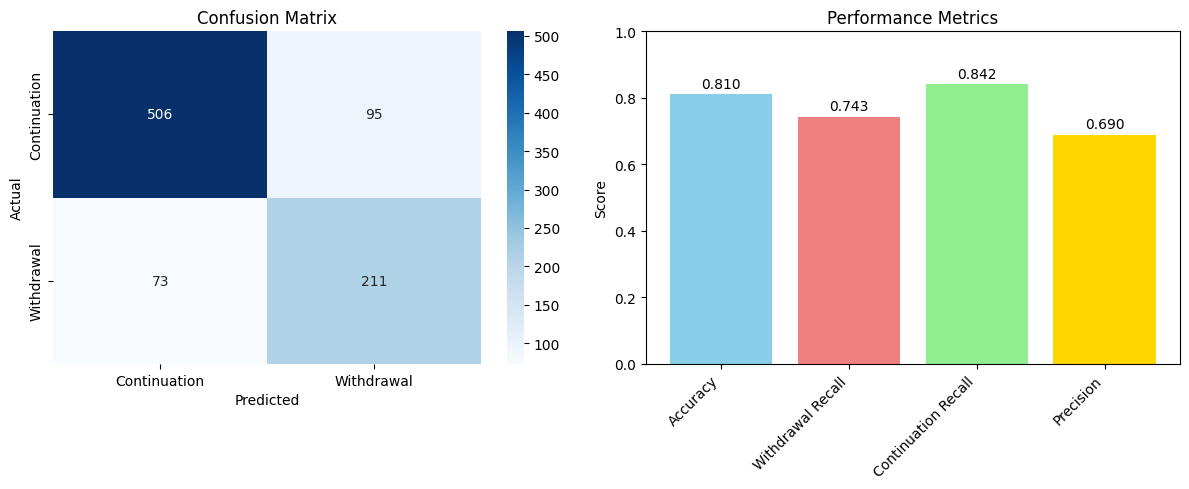

✅ Logistic Regression Model Complete!

Best configuration: C=0.1, penalty=l2

In [25]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Validate confusion matrix shape
if cm.shape != (2, 2):
    raise ValueError(f'Expected 2x2 confusion matrix, got {cm.shape}. Check that both classes are present in predictions.')

# Calculate specific metrics for withdrawal prediction
tn, fp, fn, tp = cm.ravel()
withdrawal_recall = tp / (tp + fn)  # Class-1 recall (withdrawals)
continuation_recall = tn / (tn + fp)  # Class-0 recall (continuations)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision for withdrawals

print('📊 Model Performance:')
print(f'   Accuracy: {accuracy:.3f}')
print(f'   Withdrawal recall (class-1): {withdrawal_recall:.3f}')
print(f'   Continuation recall (class-0): {continuation_recall:.3f}')
print(f'   Precision (withdrawal): {precision:.3f}')

# Add explicit note about CV scorer alignment
print(f'\n🔍 CV Scorer Alignment:')
print(f'   Grid search optimised: Class-1 recall = {withdrawal_recall:.3f}')
print(f'   Best CV score was: {grid_search.best_score_:.3f}')

print(f'\n🎯 Confusion Matrix:')
print(f'   True Negatives (correct continuations): {tn}')
print(f'   False Positives (incorrectly predicted withdrawals): {fp}')
print(f'   False Negatives (missed withdrawals): {fn}')
print(f'   True Positives (correct withdrawals): {tp}')

# Detailed classification report
print(f'\n📈 Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Continuation', 'Withdrawal']))

# Create visualisation of results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Continuation', 'Withdrawal'],
           yticklabels=['Continuation', 'Withdrawal'],
           ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Performance Metrics Bar Chart
metrics = ['Accuracy', 'Withdrawal Recall', 'Continuation Recall', 'Precision']
values = [accuracy, withdrawal_recall, continuation_recall, precision]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = axes[1].bar(metrics, values, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Performance Metrics')
axes[1].set_ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f'✅ Logistic Regression Model Complete!')
print(f'Best configuration: C={grid_search.best_params_["classifier__C"]}, '
      f'penalty={grid_search.best_params_["classifier__penalty"]}')

Getting probability predictions from Logistic Regression model...

Creating Professional Threshold vs Performance Chart for Logistic Regression

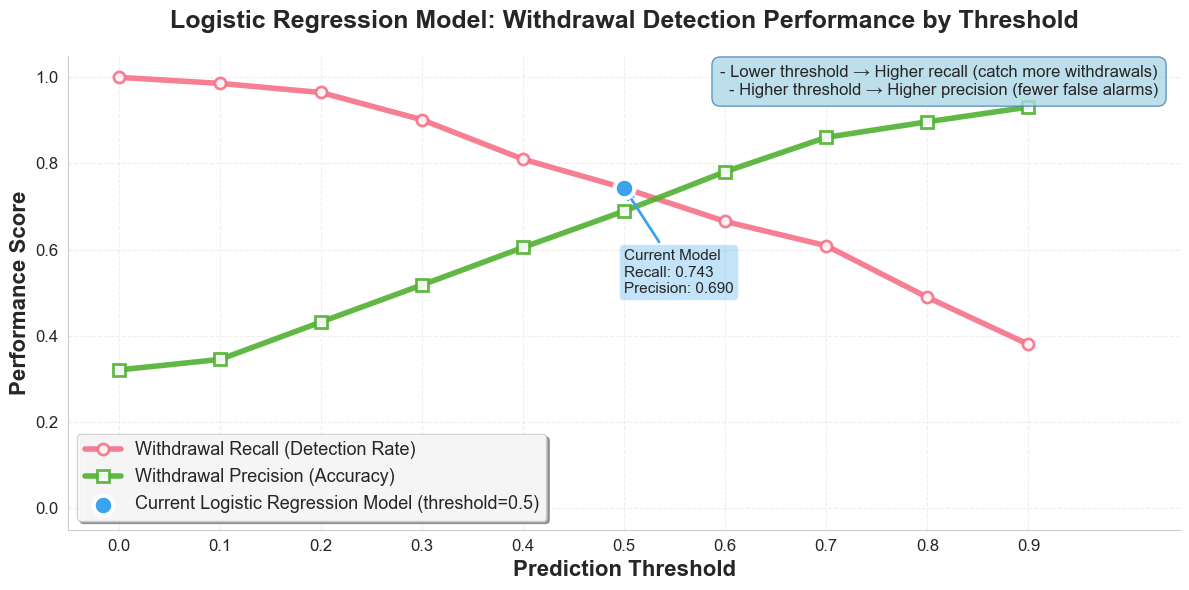

- Logistic Regression THRESHOLD PERFORMANCE ANALYSIS

Threshold  Withdrawal_Recall  Withdrawal_Precision  F1_Score    Status
       0.0              1.000                 0.321     0.486          
       0.1              0.986                 0.345     0.511          
       0.2              0.965                 0.432     0.597          
       0.3              0.901                 0.518     0.658          
       0.4              0.810                 0.605     0.693          
       0.5              0.743                 0.690     0.715 ← CURRENT
       0.6              0.665                 0.781     0.719          
       0.7              0.609                 0.861     0.713          
       0.8              0.489                 0.897     0.633          
       0.9              0.380                 0.931     0.540

- THRESHOLD RECOMMENDATIONS

- Balanced Performance (Best F1)      threshold = 0.6 (F1=0.719)

- Maximum Detection (Best Recall)     threshold = 0.0 (Recall=1.000)

- Minimum False Alarms (Best Precision) threshold = 0.9 (Precision=0.931)

In [26]:
# Set professional seaborn style
sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Get probability predictions for threshold analysis
print('Getting probability predictions from Logistic Regression model...')
# Note: Make sure y_pred_proba is from your logistic regression model
# y_pred_proba = best_lr_model.predict_proba(X_test)[:, 1]  # Probability of withdrawal (class 1)

# Threshold vs Performance Chart
print('Creating Professional Threshold vs Performance Chart for Logistic Regression')

# Define threshold range (0.0 to 1.0 in 0.1 increments)
thresholds = np.arange(0.0, 1.0, 0.1)

# Store results
withdrawal_precisions = []
withdrawal_recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Make predictions using this threshold
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Calculate confusion matrix
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    
    # Handle edge cases where no predictions are made for a class
    if cm_thresh.shape != (2, 2):
        # If threshold is too high/low, some classes might not be predicted
        if threshold >= 1.0:
            # No withdrawals predicted
            withdrawal_recalls.append(0.0)
            withdrawal_precisions.append(0.0)
        else:
            # All predicted as withdrawals
            withdrawal_recalls.append(1.0)
            withdrawal_precisions.append(sum(y_test) / len(y_test))
    else:
        tn, fp, fn, tp = cm_thresh.ravel()
        
        # Withdrawal recall (sensitivity for class 1)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        # Withdrawal precision (positive predictive value for class 1)  
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        
        withdrawal_recalls.append(recall)
        withdrawal_precisions.append(precision)

# Create professional plot with seaborn styling
fig, ax = plt.subplots(figsize=(12, 6))

# Define professional color palette
colors = sns.color_palette('husl', 3)
recall_color = colors[0]  # Blue-ish
precision_color = colors[1]  # Orange-ish
current_color = colors[2]  # Green-ish

# Plot both lines with enhanced styling
ax.plot(thresholds, withdrawal_recalls, 
        color=recall_color, linewidth=4, marker='o', markersize=8, 
        markerfacecolor='white', markeredgecolor=recall_color, markeredgewidth=2,
        label='Withdrawal Recall (Detection Rate)', alpha=0.9)

ax.plot(thresholds, withdrawal_precisions, 
        color=precision_color, linewidth=4, marker='s', markersize=8,
        markerfacecolor='white', markeredgecolor=precision_color, markeredgewidth=2,
        label='Withdrawal Precision (Accuracy)', alpha=0.9)

# Mark current model (0.5 threshold) with enhanced styling
current_idx = 5  # 0.5 is at index 5 in our array
ax.scatter(0.5, withdrawal_recalls[current_idx], s=200, 
          color=current_color, edgecolor='white', linewidth=3, zorder=5,
          label=f'Current Logistic Regression Model (threshold=0.5)')

# Add annotation for current model
ax.annotate(f'Current Model\nRecall: {withdrawal_recalls[current_idx]:.3f}\nPrecision: {withdrawal_precisions[current_idx]:.3f}',
            xy=(0.5, withdrawal_recalls[current_idx]), 
            xytext=(0.5, 0.5), fontsize=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=current_color, alpha=0.3),
            arrowprops=dict(arrowstyle='->', color=current_color, lw=2))

# Enhanced formatting
ax.set_xlabel('Prediction Threshold', fontsize=16, fontweight='bold')
ax.set_ylabel('Performance Score', fontsize=16, fontweight='bold')
ax.set_title('Logistic Regression Model: Withdrawal Detection Performance by Threshold', 
             fontsize=18, fontweight='bold', pad=20)

# Customise grid
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Enhanced legend - moved to bottom left
legend = ax.legend(fontsize=13, frameon=True, shadow=True, 
                   fancybox=True, framealpha=0.9, loc='lower left')
legend.get_frame().set_facecolor('white')

# Set limits and ticks
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(thresholds)
ax.set_xticklabels([f'{t:.1f}' for t in thresholds], fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add professional text box with guidance - moved to top right to avoid legend
textstr = '''- Lower threshold → Higher recall (catch more withdrawals)
- Higher threshold → Higher precision (fewer false alarms)'''

ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8,
                 edgecolor='steelblue', linewidth=1))

# Remove top and right spines for cleaner look
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

# Create professional results table
results_df = pd.DataFrame({
    'Threshold': thresholds,
    'Withdrawal_Recall': withdrawal_recalls,
    'Withdrawal_Precision': withdrawal_precisions
})

# Calculate F1 scores
f1_scores = []
for i, threshold in enumerate(thresholds):
    if withdrawal_precisions[i] + withdrawal_recalls[i] > 0:
        f1 = 2 * (withdrawal_precisions[i] * withdrawal_recalls[i]) / (withdrawal_precisions[i] + withdrawal_recalls[i])
    else:
        f1 = 0.0
    f1_scores.append(f1)

results_df['F1_Score'] = f1_scores
results_df = results_df.round(3)

# Add status column
results_df['Status'] = results_df['Threshold'].apply(lambda x: '← CURRENT' if x == 0.5 else '')

# Style the dataframe display
print(' - Logistic Regression THRESHOLD PERFORMANCE ANALYSIS')
print(results_df.to_string(index=False))

# Professional recommendations section
print(' - THRESHOLD RECOMMENDATIONS')

best_f1_idx = np.argmax(f1_scores)
best_recall_idx = np.argmax(withdrawal_recalls)
best_precision_idx = np.argmax(withdrawal_precisions)

recommendations = [
    ('   - Balanced Performance (Best F1)', thresholds[best_f1_idx], f'F1={f1_scores[best_f1_idx]:.3f}'),
    ('   - Maximum Detection (Best Recall)', thresholds[best_recall_idx], f'Recall={withdrawal_recalls[best_recall_idx]:.3f}'),
    ('   - Minimum False Alarms (Best Precision)', thresholds[best_precision_idx], f'Precision={withdrawal_precisions[best_precision_idx]:.3f}')
]

for desc, threshold, metric in recommendations:
    print(f'{desc:<40} threshold = {threshold:.1f} ({metric})')

# Reset matplotlib style to default for subsequent plots
plt.style.use('default')